# LSTM with Explainability using an attention layer

In this notebook introduces a prediction using a Long Short-Term Memory (LSTM) with explainability. The data set used is "Power consumption of Tetouan city Data Set" from UCI Machine Learning Repository.


## Libraries

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow import keras
from keras import Model
from keras.layers import Layer

In [3]:
from keras.layers.core import Dense, Reshape, Permute

In [4]:
seed = 7
keras.utils.set_random_seed(seed)
np.random.seed(seed)

## Data Processing

In [5]:
data = pd.read_csv('Tetuan_City_power_consumption.csv',delimiter=',')
n = len(data)
data.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [6]:
data.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

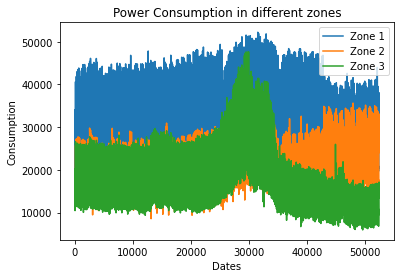

In [7]:
x = range(n)
plt.plot(x,data['Zone 1 Power Consumption'], label="Zone 1")
plt.plot(x,data['Zone 2  Power Consumption'], label="Zone 2")
plt.plot(x,data['Zone 3  Power Consumption'], label="Zone 3")
plt.title("Power Consumption in different zones")
plt.xlabel("Dates")
plt.ylabel("Consumption")
plt.legend()

In [8]:
norma_df = lambda data: (data - data.min()) / (data.max() - data.min())

## Training

Predicting Zone 1

In [9]:
y = data['Zone 1 Power Consumption']
X = data[['Temperature', 'Humidity', 'Wind Speed','general diffuse flows', 'diffuse flows']]

In [10]:
def add_lags(dataset):
    mt = []
    for i in range(3, len(dataset)):
        a = [dataset['Temperature'][i - 3], dataset['Temperature'][i - 2], dataset['Temperature'][i - 1], 
             dataset['Temperature'][i]]
        b = [dataset['Humidity'][i - 3], dataset['Humidity'][i - 2], dataset['Humidity'][i - 1], dataset['Humidity'][i]]
        c = [dataset['Wind Speed'][i - 3], dataset['Wind Speed'][i - 2], dataset['Wind Speed'][i - 1], 
             dataset['Wind Speed'][i]]
        d = [dataset['general diffuse flows'][i - 3], dataset['general diffuse flows'][i - 2], dataset['general diffuse flows'][i - 1],
             dataset['general diffuse flows'][i]]
        e = [dataset['diffuse flows'][i - 3], dataset['diffuse flows'][i - 2], dataset['diffuse flows'][i - 1],
             dataset['diffuse flows'][i]]
        mt.append([a, b, c, d, e])
    return np.array(mt)
    

Splitting into Train and Test dataset

In [11]:
y_training, y_testing = y[3:int(n*0.75)].reset_index(drop=True), y[int(n*0.75)+3:n].reset_index(drop=True)
X_training, X_testing = X[0:int(n*0.75)].reset_index(drop=True), X[int(n*0.75):n].reset_index(drop=True)

Normalization

In [12]:
X_training, X_testing = norma_df(X_training), norma_df(X_testing)

Adding lag variables to add into the LSTM model

In [13]:
X_training, X_testing = add_lags(X_training), add_lags(X_testing)

The attention layer based in the work of Kaji et al. (2019) and helps to elucidate the weights from the inputs.

In [14]:
def attention_layer(inputs, steps):
    x = Permute((2, 1))(inputs)
    x = Reshape((int(inputs.shape[2]), steps))(x)
    x = Dense(steps, activation='softmax')(x)
    a = Permute((2, 1), name='attention_layer')(x)
    return keras.layers.multiply([inputs, a])

LSTM model to predict the Zone 1 Power Consumption

In [15]:
epochs_n = 128
batch_size_n = 64

In [16]:
inputs_x = keras.layers.Input(shape=(5, 4))

x = attention_layer(inputs_x, 5)
x = keras.layers.Masking(mask_value=0, input_shape=(5, 4))(x)
x = keras.layers.LSTM(64, return_sequences=False, return_state=False, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
out_model = keras.layers.Dense(1, activation="relu")(x)

model = keras.Model(inputs=inputs_x, outputs=[out_model])
model.compile(loss='mse', optimizer='adam')
model.fit(X_training,y_training, epochs = epochs_n, batch_size = batch_size_n)

Epoch 1/128
615/615 [==============================] - 9s 8ms/step - loss: 222435088.0000
Epoch 2/128
615/615 [==============================] - 4s 7ms/step - loss: 45705284.0000
Epoch 3/128
615/615 [==============================] - 4s 6ms/step - loss: 44530176.0000
Epoch 4/128
615/615 [==============================] - 4s 6ms/step - loss: 44035668.0000
Epoch 5/128
615/615 [==============================] - 4s 6ms/step - loss: 43464980.0000
Epoch 6/128
615/615 [==============================] - 4s 6ms/step - loss: 43021912.0000
Epoch 7/128
615/615 [==============================] - 4s 6ms/step - loss: 42698848.0000
Epoch 8/128
615/615 [==============================] - 4s 6ms/step - loss: 42470168.0000
Epoch 9/128
615/615 [==============================] - 4s 7ms/step - loss: 42402944.0000
Epoch 10/128
615/615 [==============================] - 4s 6ms/step - loss: 42230848.0000
Epoch 11/128
615/615 [==============================] - 5s 8ms/step - loss: 42030564.0000
Epoch 12/128
615/6

615/615 [==============================] - 5s 8ms/step - loss: 32667862.0000
Epoch 93/128
615/615 [==============================] - 4s 6ms/step - loss: 32665630.0000
Epoch 94/128
615/615 [==============================] - 4s 7ms/step - loss: 32584404.0000
Epoch 95/128
615/615 [==============================] - 4s 7ms/step - loss: 32651630.0000
Epoch 96/128
615/615 [==============================] - 4s 6ms/step - loss: 32486986.0000
Epoch 97/128
615/615 [==============================] - 6s 9ms/step - loss: 32539864.0000
Epoch 98/128
615/615 [==============================] - 6s 9ms/step - loss: 32509014.0000
Epoch 99/128
615/615 [==============================] - 4s 6ms/step - loss: 32469300.0000
Epoch 100/128
615/615 [==============================] - 4s 6ms/step - loss: 32427650.0000
Epoch 101/128
615/615 [==============================] - 4s 6ms/step - loss: 32448264.0000
Epoch 102/128
615/615 [==============================] - 4s 7ms/step - loss: 32483958.0000
Epoch 103/128
615/61

Prediction from the LSTM model

In [17]:
y_pred = model.predict(X_testing)
y_pred = np.squeeze(y_pred)

410/410 [==============================] - 2s 2ms/step


Plot the predicted values

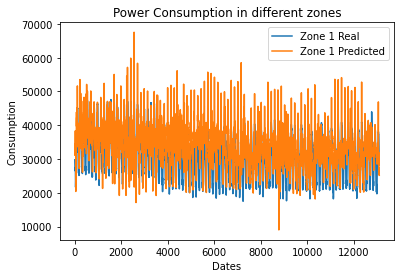

In [18]:
x = range(len(y_testing))
plt.plot(x,y_testing, label="Zone 1 Real")
plt.plot(x,y_pred, label="Zone 1 Predicted")
plt.title("Power Consumption in different zones")
plt.xlabel("Dates")
plt.ylabel("Consumption")
plt.legend()

## Explainability

Using a layer of attention between the input and the LSTM layer it is possible to obtain a degree of explanations. The attention values are a vector of real values that sums one.

In [19]:
model_output = model.get_layer("attention_layer").output
partial_extraction = Model(inputs = model.input, outputs=model_output)
attention_values = np.array(partial_extraction(X_testing))

We obtain the partial values from the attention model and collect the corresponding to the actual observation and we do not consider the lagged values (t-1, t-2, t-3)

In [20]:
t = []
for i in range(0,len(X_testing),90):
    q = attention_values[i][:,3:4]
    q = np.squeeze(q)
    t.append(q)
t = np.array(t).T

Once the attention values are filtered, we can present them in a heatmap and see the evolution on time.

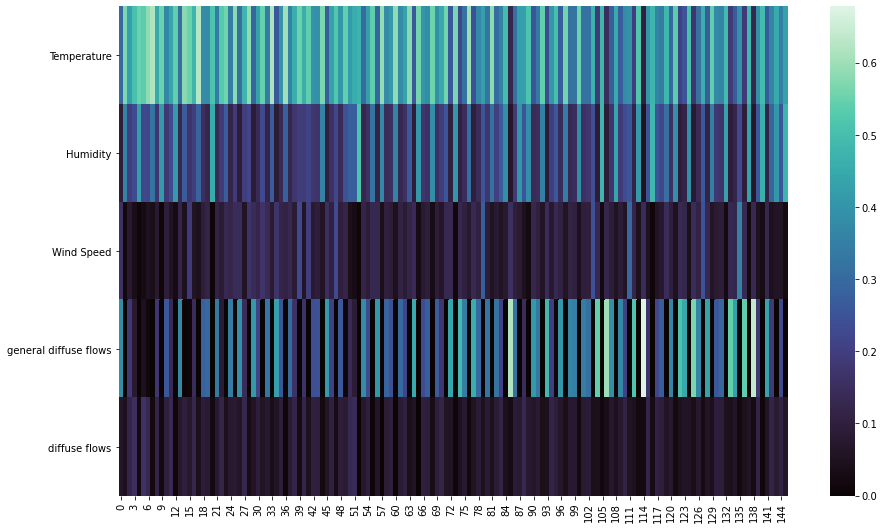

In [21]:
f, ax = plt.subplots(figsize=(15, 9))
y_axis_labels = ['Temperature', 'Humidity', 'Wind Speed','general diffuse flows', 'diffuse flows'] # labels for y-axis
sns.heatmap(t, yticklabels=y_axis_labels, cmap="mako")
plt.show()

## References

Kaji, D. A., Zech, J. R., Kim, J. S., Cho, S. K., Dangayach, N. S., Costa, A. B., & Oermann, E. K. (2019). An attention based deep learning model of clinical events in the intensive care unit. PloS one, 14(2), e0211057.

Lundberg, S. M., & Lee, S. I. (2017). A unified approach to interpreting model predictions. Advances in neural information processing systems, 30.

Salam, A., & El Hibaoui, A. (2018, December). Comparison of Machine Learning Algorithms for the Power Consumption Prediction:-Case Study of Tetouan cityâ€“. In 2018 6th International Renewable and Sustainable Energy Conference (IRSEC) (pp. 1-5). IEEE.â€

Data: https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city